In [1]:
# Unzip the downloaded dataset
!unzip Processed_Soil_Classification.zip -d /content/Soil-classification-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2017-05-09_class_1_patch_60.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2017-01-27_class_1_patch_81.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2016-05-02_class_1_patch_80.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2017-05-15_class_1_patch_37.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2016-04-08_class_1_patch_81.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2019-07-16_class_1_patch_34.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2015-05-05_class_1_patch_36.png  
  inflating: /content/Soil-classification-dataset/Dry/soil_moisture_india_and_sri_lanka_2019-04

Epoch [1/200], Train Loss: 0.0532, Train Accuracy: 97.93%, Val Loss: 0.0369, Val Accuracy: 98.30%
Epoch [2/200], Train Loss: 0.0170, Train Accuracy: 99.48%, Val Loss: 0.0132, Val Accuracy: 99.70%
Epoch [3/200], Train Loss: 0.0158, Train Accuracy: 99.40%, Val Loss: 0.0201, Val Accuracy: 99.03%
Epoch [4/200], Train Loss: 0.0134, Train Accuracy: 99.57%, Val Loss: 0.0468, Val Accuracy: 98.23%
Epoch [5/200], Train Loss: 0.0153, Train Accuracy: 99.53%, Val Loss: 0.0710, Val Accuracy: 98.20%
Epoch [6/200], Train Loss: 0.0224, Train Accuracy: 99.50%, Val Loss: 0.0064, Val Accuracy: 99.67%
Epoch [7/200], Train Loss: 0.0062, Train Accuracy: 99.75%, Val Loss: 0.0454, Val Accuracy: 98.67%
Epoch [8/200], Train Loss: 0.0091, Train Accuracy: 99.74%, Val Loss: 0.0075, Val Accuracy: 99.63%
Epoch [9/200], Train Loss: 0.0039, Train Accuracy: 99.86%, Val Loss: 0.0126, Val Accuracy: 99.53%
Epoch [10/200], Train Loss: 0.0038, Train Accuracy: 99.86%, Val Loss: 0.0087, Val Accuracy: 99.57%
Epoch [11/200], Tra

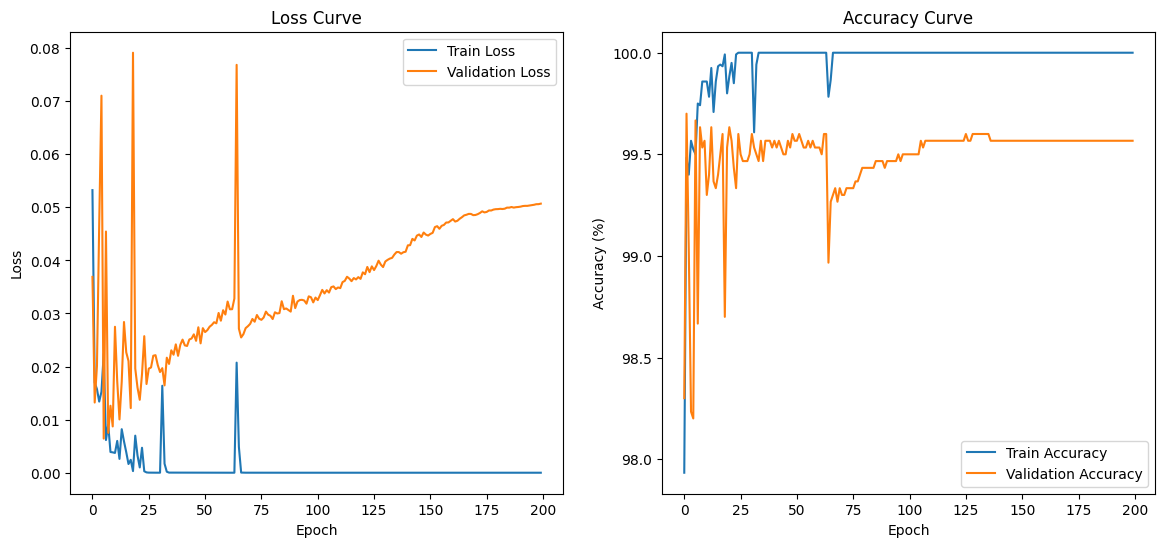

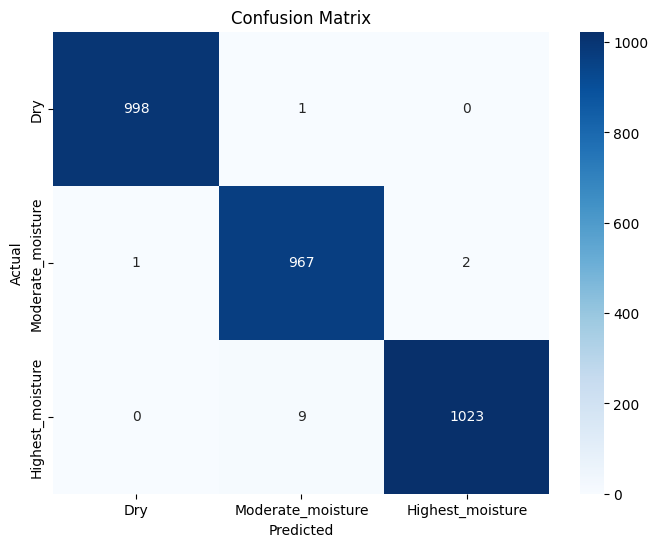

Classification Report:
                   precision    recall  f1-score   support

              Dry       1.00      1.00      1.00       999
Moderate_moisture       0.99      1.00      0.99       970
 Highest_moisture       1.00      0.99      0.99      1032

         accuracy                           1.00      3001
        macro avg       1.00      1.00      1.00      3001
     weighted avg       1.00      1.00      1.00      3001



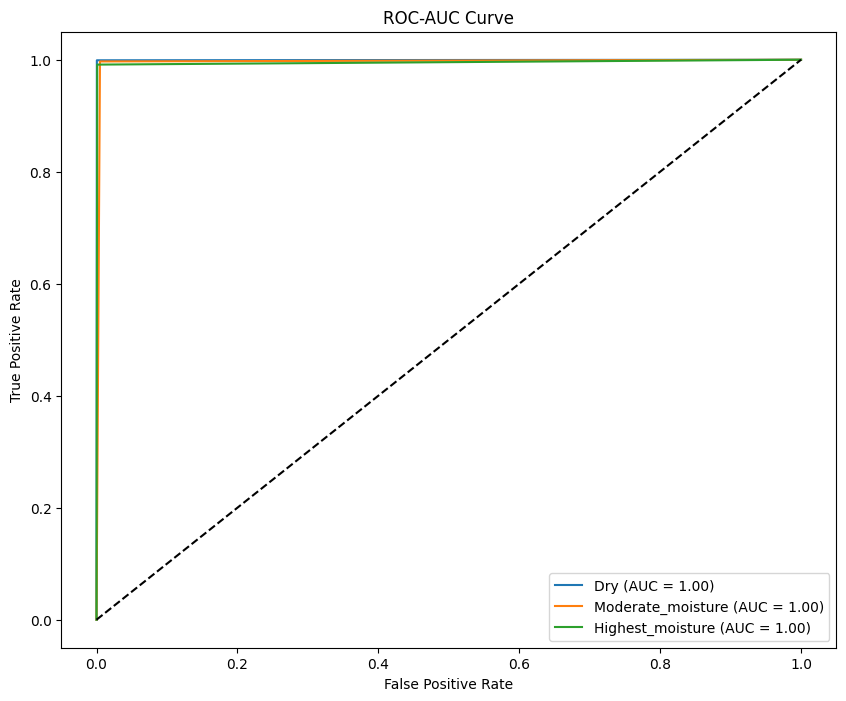

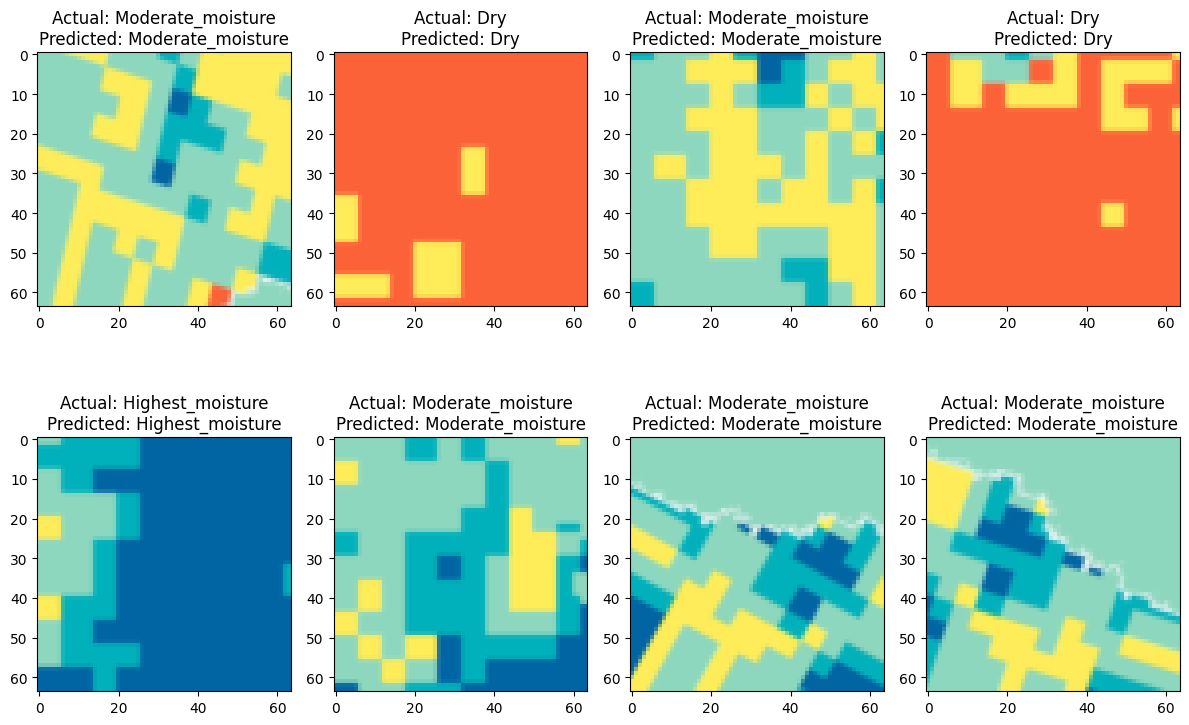

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random
import os
import math
import tensorflow as tf

s=1337
np.random.seed(s)
random.seed(s)
tf.random.set_seed(s)

# Custom Dataset
class SoilMoistureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self._initialize_fc()
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _initialize_fc(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 64, 64)
            x = self.pool(self.relu(self.conv1(dummy_input)))
            x = self.pool(self.relu(self.conv2(x)))
            self.flattened_size = x.numel()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)

        # Validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_accuracy.append(100 * val_correct / val_total)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%")

    return train_loss, train_accuracy, val_loss, val_accuracy

# Plot Loss and Accuracy
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.savefig("soil_moisture_acc_loss_curve.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

# Confusion Matrix and Classification Report
def evaluate_model(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("soil_moisture_cm.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds

# ROC Curve
def plot_roc_curve(labels, preds, num_classes, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(np.array(labels) == i, np.array(preds) == i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend()
    plt.savefig("soil_moisture_roc-auc.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

# Main Script
if __name__ == "__main__":
    base_path = "/content/Soil-classification-dataset/"
    class_folders = ["Dry", "Moderate_moisture", "Highest_moisture"]

    image_paths, labels = [], []
    class_to_label = {"Dry": 0, "Moderate_moisture": 1, "Highest_moisture": 2}

    for class_name in class_folders:
        class_folder_path = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_folder_path):
            file_path = os.path.join(class_folder_path, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(file_path)
                labels.append(class_to_label[class_name])

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = SoilMoistureDataset(image_paths, labels, transform=transform)

    # Split dataset into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNModel(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=200
    )

    # Plot metrics
    plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

    # Evaluate the model
    class_names = ["Dry", "Moderate_moisture", "Highest_moisture"]
    all_labels, all_preds = evaluate_model(model, val_loader, class_names)

    # Plot ROC Curve
    plot_roc_curve(all_labels, all_preds, num_classes=3, class_names=class_names)

    # Show validation images with predictions
    val_images, val_labels = next(iter(val_loader))
    val_images, val_labels = val_images.to(device), val_labels.to(device)
    val_outputs = model(val_images)
    _, val_preds = torch.max(val_outputs, 1)

    # Limit number of images to 8
    num_images = min(len(val_images), 8)  # Ensure no more than 8 images are plotted
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(val_images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f"Actual: {class_names[val_labels[i].item()]}\nPredicted: {class_names[val_preds[i].item()]}")
    plt.tight_layout()
    plt.savefig("soil_moisture_prediction.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()